0.0028990482 0.0069599627


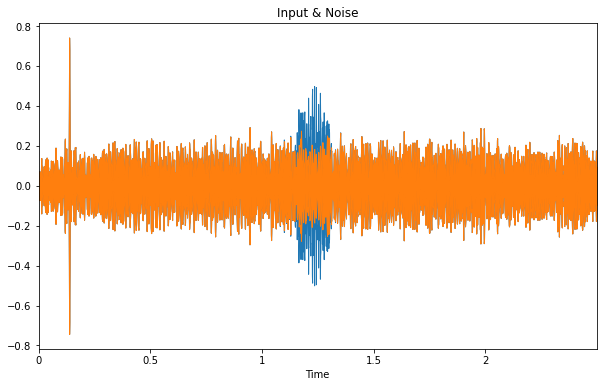

In [1]:
# From lab4(previous codes)
import sys
import numpy as np
import matplotlib
import librosa
from matplotlib import pyplot as plt
import librosa.display

#from scipy.io import wavfile
from scipy import signal
from scipy.fft import fftshift
from IPython.display import Audio
import soundfile

def getFIRFFT(H,order, flag_window=1, flag_display=0):
    
    NFFT=len(H)*2-1
    # real 부분을 뒤집어서 pi~ 2pi부분에 넣는다.
    mirrored=np.concatenate([H,np.flip(np.conjugate(H[0:-1]),axis=0)],axis=0)
    mirrored=mirrored+(0j)
    
    # 중앙을 기준으로 좌우 대칭인 것을 ifft한다.
    iffted=np.fft.ifft(mirrored, axis=0)
    iffted=np.concatenate([iffted[len(H):], iffted[0:len(H)]])

    if flag_display==1: # 디버깅용 플롯
        plt.figure()
        plt.plot(np.arange(len(mirrored))*np.pi*2/len(mirrored),mirrored)
        plt.title("Mirrored time-domain signal")

        plt.figure()
        plt.plot(np.arange(len(iffted)),np.real(iffted))
        plt.title("iffted signal")
        
    # 원하는 order에 해당하는 만큼만 잘라낸다.
    h=iffted[len(H)-order//2:len(H)+order//2 ]
    h=h.real
    
    if flag_window ==1: # 필요하다면 hamming window를 적용한다.
        window=signal.windows.hamming(len(h))
        h=h*window    
    return h

def Visualize_plots(h,H_wanted): # 플롯 띄우는 함수
    # h : 시간차원에서의 신호
    # H_wanted : 원하는 주파수 응답
    
    H_result=np.abs(np.fft.fft(h,1024))
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.plot(np.arange(len(h)),h)
    plt.title("time-domain filter result")
    plt.subplot(1,2,2)
    plt.plot(np.arange(len(H_result)//2)*np.pi/(len(H_result)//2),H_result[:len(H_result)//2])
    plt.plot(np.arange(len(H_wanted))*np.pi/len(H_wanted),H_wanted)
    plt.title("Freq response of filter")
    plt.legend(["result","wanted"])
    plt.show()
    
def Spectrogram(x,Ns,Nf,flag_hamm):
    # x : 음성신호
    # Ns: shift number of samples
    # Nf: frame number of samples
    # flag_hmm: switch for hamming window 1/0 (ON/OFF)
    T = len(x)   # number of samples
    #num_frames = T//Nf# 마지막 채워지지 않은 프레임은 버린다. 구현에 따라 zero-padding해서 사용 가능
    num_frames = (T-Nf)//Ns + 1 
    hNo = Nf//2+1

    X = np.zeros((hNo,num_frames),dtype="complex")
    
    if flag_hamm >0: # window setting
        win = librosa.filters.get_window('hamming', Nf, fftbins=True)
    else:
        win = np.ones(Nf)
        
    for i in range(num_frames):
        y = x[(i*Ns):(i*Ns+Nf)]

        y=np.fft.fft(y*win) 
        X[:,i]= y[:hNo]

    return X

def filtering(h, x, prevx,out_len):# 필터링 후 원하는 길이만큼 출력해주는 함수
    # h : 시간차원 필터
    # x : 시간차원 신호
    # prevx : 버퍼 초기화
    # out_len : 원하는 출력 길이
    Lx=len(x)
    x_i=np.concatenate([prevx,x])
    y=np.convolve(x_i,h,"same")
    
    prevx=x_i[-len(prevx):]
    
    return y[-out_len:], prevx

def get_Wiener_filter(x,Ns,Nf,order,E_n): # wiener filter를 구해주는 함수
    # x : 시간차원 신호
    # Ns: shift할 길이
    # Nf: 프레임의 크기
    # order: wiener filter의 크기
    # E_n : 추정된 noise의 주파수 특성
    X=np.squeeze(Spectrogram(x,Ns,Nf,1))
    E_x=np.real(np.conj(X)*X)
    H=(E_x-E_n)/E_x
    H[H < 1/32]=1/32 # clipping
    h=getFIRFFT(H,order,) # time-domain filter
    
    return h

def trapezoidal_mixing(f_idx, Nf,Nover,y,y_tmp,upslope): # trapezoidal mixing을 해주는 함수
    # f_idx : 현재 프레임 번호
    # Nf : 프레임의 길이
    # Nover : overlap될 길이
    # y : 결과를 저장할 배열
    # y_tmp : 입력된 데이터
    # upslope : mixing할 가중치 배열
    if (f_idx-1)*Nf-Nover>=0: # trapezoidal window의 적용
        y[(f_idx-1)*Nf-Nover:(f_idx-1)*Nf]=y[(f_idx-1)*Nf-Nover:(f_idx-1)*Nf]+upslope*y_tmp[:Nover]
        y[(f_idx-1)*Nf:(f_idx)*Nf]=y_tmp[Nover:]
        y[(f_idx)*Nf-Nover:(f_idx)*Nf]=y[(f_idx)*Nf-Nover:(f_idx)*Nf]*np.flip(upslope)
    else:
        y[(f_idx-1)*Nf:(f_idx)*Nf]=y_tmp[Nover:]
        y[(f_idx)*Nf-Nover:(f_idx)*Nf]=y[(f_idx)*Nf-Nover:(f_idx)*Nf]*np.flip(upslope)        
    return y


x_, Fs=librosa.load("./kdigits1-3.wav") # 시간차원에서의 음성 신호
n, Fs=librosa.load("./lab04_car.wav")   # 노이즈 신호

L_min=min(len(x_),len(n))
x_=x_[:L_min]
n=n[:L_min]
E_x=np.mean(x_[Fs:3*Fs//2]**2)
E_n=np.mean(n**2)
print(E_x, E_n)
SNR=10**(10/20)
n=n*E_x/E_n*SNR

x= n+x_ # SNR을 고려한 mixing

Ts=0.01 # 10ms
Tf=0.01 # 10ms
Tover=0.003
Ns=int(Fs*Ts)
Nf=int(Fs*Tf)
Nover=int(Fs*Tover) # overlap될 길이 (trapezoidal의 사용을 위해 정의됨)
upslope=np.linspace(0,1,Nover+2)[1:-1]

plt.figure(figsize=[10,6])
librosa.display.waveplot(x,Fs)
librosa.display.waveplot(n,Fs)
plt.title("Input & Noise")

soundfile.write("./mixed_signal.wav",x,Fs,format="WAV")

1.6156455e-05 0.024085658
-4.7547288e-05 0.10988842


Text(0.5, 1.0, 'PDF of Estimations')

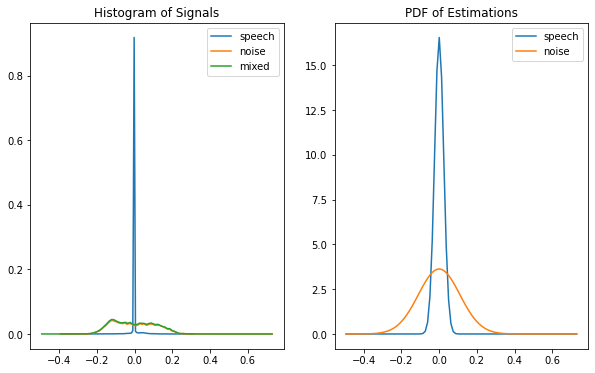

In [2]:
# 0. draw signals characteristics
#####################################################################
# histogram으로 데이터의 통계적 특성을 추정한다.
# 노이즈와 음성 신호를 각각 gaussian으로 가정하고,
# 평균, 분산을 얻어서, 추정한다.

# SNR이 12dB이상이 되니까 histogram 상에서 noise, mixed를 구분할 수 없었다.
# 이상황에서는 아래의 알고리즘들이 잘 동작하지 않는 것을 확인할 수 있었는데,
# 통계적으로 noise와 mixed를 구분할 수 없는 조건이 있는 것으로 생각된다.
#####################################################################

sp, bin_sp=np.histogram(x_,100)
noi, bin_no=np.histogram(n,100)
mixed, bin_mixed=np.histogram(x,100)

def gaussian(x,mu,sigma):# 단일 변수 gaussian함수
    # x : 데이터
    # mu : 평균
    # sigma : 표준 편차
    return np.exp(-(x-mu)**2/(2*sigma**2))/(np.sqrt(2*np.pi*sigma**2))

# 평균을 추정
mean_sp=np.mean(x_)
mean_noi=np.mean(n)

# 표준편차를 추정
sig_sp=np.sqrt(np.mean((x_-mean_sp)**2))
sig_n=np.sqrt(np.mean((n-mean_noi)**2))
print(mean_sp,sig_sp)
print(mean_noi,sig_n)

p_x_est=gaussian(bin_mixed[:-1],mean_sp,sig_sp)
p_n_est=gaussian(bin_mixed[:-1],mean_noi,sig_n)

# 시각화
plt.figure(figsize=[10,6])
plt.subplot(1,2,1)
plt.plot(bin_sp[:-1],sp/len(x_))
plt.plot(bin_no[:-1],noi/len(n))
plt.plot(bin_mixed[:-1],mixed/len(x))
plt.legend(['speech','noise','mixed'])
plt.title("Histogram of Signals")
plt.subplot(1,2,2)
plt.plot(bin_mixed[:-1],p_x_est)
plt.plot(bin_mixed[:-1],p_n_est)
plt.legend(['speech','noise'])
plt.title("PDF of Estimations")


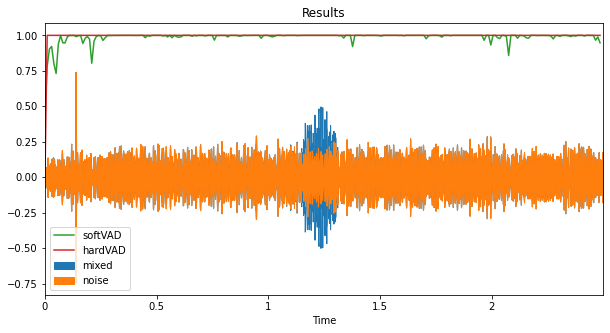

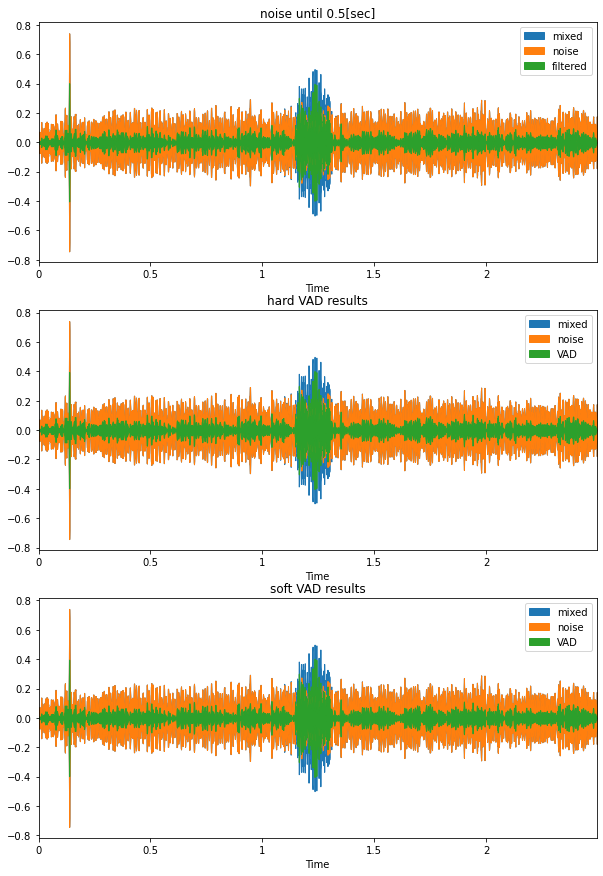

In [3]:
# 1. noise spectrum estimation and suppression by probabilistic VAD
#####################################################################
# 구한 통계적 특성으로 noise를 표현할 수 있다.
# speech는 실제로는 Laplacian Distribution을 따르지만, 
# 편의를 위해 Gaussian으로 모사한다.
#####################################################################

P_voice=0.5

max_iter=int(len(x)/Ns)

def Soft_Decision(P_voice,P_n,P_x): # 1변수 soft decision을 위한 함수
    # P_voice : 음성신호가 있을 확률
    # P_n : 노이즈의 likelyhood
    # P_x : 음성신호의 likelyhood
    denom=(1-P_voice)*P_n+(P_voice)*P_x
    P_n_given_y=(1-P_voice)*P_n/denom

    return P_n_given_y

soft_VAD_frame=np.zeros(max_iter)

for idx in range(max_iter):
    x_i=x[(idx)*Ns:(idx)*Ns+Nf]
    x_k=np.sqrt(np.mean(x_i**2)) 
    decision_tmp=Soft_Decision(P_voice,
                                gaussian(x_k,mean_noi,sig_n),
                                gaussian(x_k,mean_sp,sig_sp),
                               )
    soft_VAD_frame[idx]=decision_tmp

# Threshold를 최대값을 절반으로 지정
hard_VAD_frame = (soft_VAD_frame > (max(soft_VAD_frame)/2))+0
# hard_VAD_frame = (soft_VAD_frame > (0.5))+0

order=30

# VAD로 추정한 noise의 Spectrogram
N=Spectrogram(x,Ns,Nf,1)
E_n_soft_VAD=np.mean(np.abs(N)*soft_VAD_frame,axis=-1) 
E_n_hard_VAD=np.mean(np.abs(N)*hard_VAD_frame,axis=-1) 

y_soft=np.zeros(int(max_iter*Nf))
y_hard=np.zeros(int(max_iter*Nf))
mem_xsoft=np.zeros(order-1+Nover) # 필터링을 위한 버퍼
mem_xhard=np.zeros(order-1+Nover) # 필터링을 위한 버퍼


# 입력신호의 0.5sec꺼지는 노이즈만 있다는 가정하의 noise spectrogram
N_noise=int(0.5*Fs)#0.5[sec]
N05=Spectrogram(x[:N_noise],Ns,Nf,1)
E_n05=np.mean(np.real(np.sqrt(N05*np.conj(N05))),axis=-1)

y_05=np.zeros(int(max_iter*Nf))
mem_x05=np.zeros(order-1+Nover) # 필터링을 위한 버퍼

for idx in range(max_iter):
    x_i=x[(idx)*Ns:(idx)*Ns+Nf]
    
    # 0.5sec까지 노이즈만 있다는 가정
    h_05=get_Wiener_filter(x_i,Ns,Nf,order,E_n05)
    y_tmp,mem_x05 = filtering(h_05,
                            x_i,
                            mem_x05,
                            Nover+Nf
                           )#  Wiener filter의 적용
    
    y_05=trapezoidal_mixing(idx+1, Nf,Nover,y_05,y_tmp,upslope)
    
    # soft VAD로 노이즈의 spectrum을 추정
    h_soft=get_Wiener_filter(x_i,Ns,Nf,order,E_n_soft_VAD)
    y_tmp,mem_xsoft = filtering(h_soft,
                            x_i,
                            mem_xsoft,
                            Nover+Nf
                           )#  Wiener filter의 적용
    y_soft=trapezoidal_mixing(idx+1, Nf,Nover,y_soft,y_tmp,upslope)

    # hard VAD로 노이즈의 spectrum을 추정
    h_hard=get_Wiener_filter(x_i,Ns,Nf,order,E_n_hard_VAD)
    y_tmp,mem_xhard = filtering(h_hard,
                            x_i,
                            mem_xhard,
                            Nover+Nf
                           )#  Wiener filter의 적용
    y_hard=trapezoidal_mixing(idx+1, Nf,Nover,y_hard,y_tmp,upslope)


# 시각화
#####################################################################
# 음성신호가 있는 부분에서 값이 급감하고, 그 외의 노이즈가 있는 구간에서는
# 큰 확률로 추정하는 것을 확인할 수 있었다.
#####################################################################

plt.figure(figsize=[10,5])
librosa.display.waveplot(x,Fs)
librosa.display.waveplot(n,Fs)
plt.plot(np.arange(0,max_iter)*Ns/Fs,soft_VAD_frame) # noise일 확률에 대한 추정
plt.plot(np.arange(0,max_iter)*Ns/Fs,hard_VAD_frame) # noise일 확률에 대한 추정
plt.legend(["softVAD","hardVAD","mixed","noise"])
plt.title("Results")

#####################################################################
# 가정을 이용한 것과 VAD를 이용한 것에 큰 차이가 없었다.
# 아마 원본 음성 신호의 분포와 SNR이 충분히 확보되어서
# 성능상의 큰 차이가 없었을 것이라 생각된다.
#####################################################################


plt.figure(figsize=[10,15])
plt.subplot(3,1,1)
librosa.display.waveplot(x,Fs)
librosa.display.waveplot(n,Fs)
librosa.display.waveplot(y_05,Fs)
plt.title("noise until 0.5[sec]")
plt.legend(["mixed","noise","filtered"])

plt.subplot(3,1,2)
librosa.display.waveplot(x,Fs)
librosa.display.waveplot(n,Fs)
librosa.display.waveplot(y_hard,Fs)
plt.title("hard VAD results")
plt.legend(["mixed","noise","VAD"])

plt.subplot(3,1,3)
librosa.display.waveplot(x,Fs)
librosa.display.waveplot(n,Fs)
librosa.display.waveplot(y_soft,Fs)
plt.title("soft VAD results")
plt.legend(["mixed","noise","VAD"])

soundfile.write("./01_result_N_0.5sec.wav",y_05,Fs,format="WAV")
soundfile.write("./01_result_N_soft.wav",y_soft,Fs,format="WAV")
soundfile.write("./01_result_N_hard.wav",y_hard,Fs,format="WAV")

0.012661108143426872 0.012668857701857267


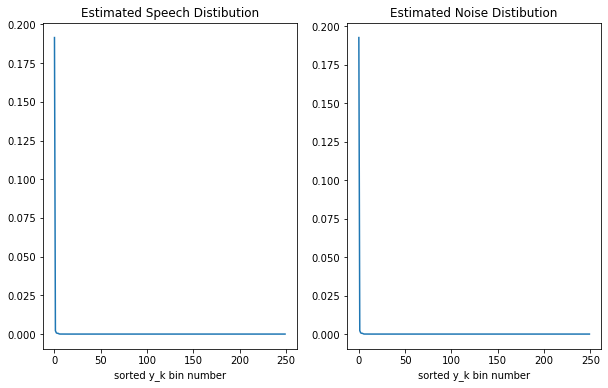

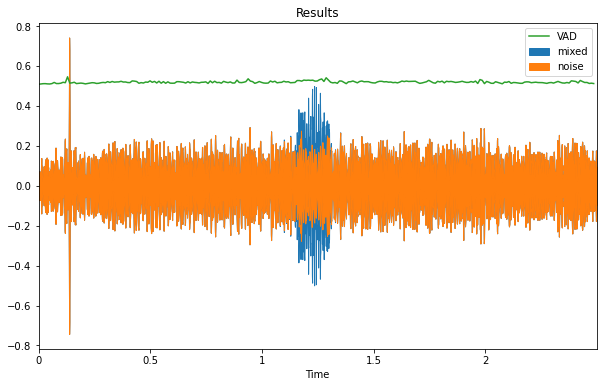

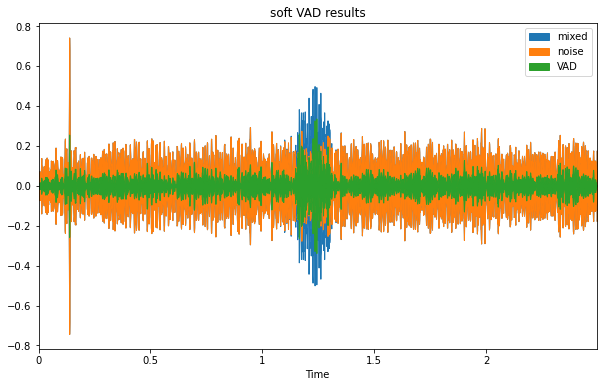

In [4]:
#2. dual Gaussian Mixture model
#####################################################################
# 두 신호를 zero-mean gaussian으로 모델링한다.
# 두 신호의 표준편차를 EM알고리즘 기반으로 구하고,
# 그것을 통해 노이즈가 있을 확률을 추정한다.
#####################################################################

def EM_Gauss(y_k,sig_x,sig_n,P_voice): # 1변수 gaussian모델에 적용될 EM
    # y_k : 스펙트럼의 에너지
    # sig_x : 음성신호의 표준편차
    # sig_n : 노이즈의 표준편차
    # P_voice : 음성신호가 있을 확률
    prob= lambda x,m_x,sig2 : np.exp(-((x-m_x)**2)/(2*sig2))/(np.sqrt(2*np.pi*sig2))
    for iter in range(3):
        Px=prob(y_k,0,sig_x) # Px(y)
        Pn=prob(y_k,0,sig_n) # Pn(y)
        
        P_v=(P_voice*Px)/(P_voice*Px+(1-P_voice)*Pn) # P(voice | y)
        P_voice=np.mean(P_v,axis=-1)# P(voice)
        
        # 각 프레임이 노이즈/음성신호 일 확률로 weighted sum을 해서
        # 표준편차를 갱신한다.
        sig_x_tmp=np.mean(P_v*(y_k**2),axis=-1)/P_voice 
        sig_n_tmp=np.mean((1-P_v)*(y_k**2),axis=-1)/(1-P_voice)
        if sig_x_tmp < sig_n_tmp:
            sig_x=sig_x_tmp
            sig_n=sig_n_tmp
        else: 
            sig_x=sig_n_tmp
            sig_n=sig_x_tmp
        
    return P_v, sig_x, sig_n ,P_voice

P_voice=0.5
max_iter=int(len(x)/Ns)
y_k=np.zeros(max_iter)
for idx in range(max_iter):
    y_k[idx]=np.sqrt(np.mean(x[(idx)*Ns:(idx)*Ns+Nf]**2,axis=-1))
y_k.sort()    
sig_x=np.mean(y_k[:max_iter//2]**2)
sig_n=np.mean(y_k[max_iter//2:]**2)
P_v,sig_x,sig_n,P_voice=EM_Gauss(y_k,sig_x,sig_n,P_voice) # EM 실행

print(sig_x,sig_n)

# 시각화
#####################################################################
# 추정한 노이즈와 음성신호의 분포를 보면,
# 거의 표준편차가 0에 가까운 것을 확인할 수 있다.
#####################################################################

plt.figure(figsize=[10,6])
plt.subplot(1,2,1)
plt.plot(np.arange(max_iter),gaussian(y_k,0,sig_x))
plt.title("Estimated Speech Distibution")
plt.xlabel("sorted y_k bin number")
plt.subplot(1,2,2)
plt.plot(np.arange(max_iter),gaussian(y_k,0,sig_n))
plt.title("Estimated Noise Distibution")
plt.xlabel("sorted y_k bin number")

# 프레임 단위의 VAD
#####################################################################
# 프레임의 에너지를 이용해서 노이즈일 확률을 추정한다.
# 추정된 노이즈와 음성신호의 분포가 거의 같기 때문에 
# 노이즈가 잘 구분되지 않는 것을 확인할 수 있다.
#####################################################################

soft_VAD=np.zeros(max_iter)
mem_xsoft=np.zeros(order-1+Nover)
y_soft=np.zeros(max_iter*Ns)                            
for idx in range(max_iter):
    x_i=x[(idx)*Ns:(idx)*Ns+Nf]
    x_k=np.sqrt(np.mean(x_i**2))
    decision_tmp=Soft_Decision(P_voice, 
                               gaussian(x_k,0,sig_n), 
                               gaussian(x_k,0,sig_x)
                              )
    soft_VAD[(idx)]=decision_tmp    
    N_est=np.abs(np.fft.fft(x_i))[0:Nf//2+1]
    h_soft=get_Wiener_filter(x_i,Ns,Nf,order,np.abs(soft_VAD[(idx)]*N_est).reshape(-1))
    y_tmp,mem_xsoft = filtering(h_soft,
                            x_i,
                            mem_xsoft,
                            Nover+Nf
                           )#  Wiener filter의 적용
    y_soft=trapezoidal_mixing(idx+1, Nf,Nover,y_soft,y_tmp,upslope)
    
plt.figure(figsize=[10,6])
librosa.display.waveplot(x,Fs)
librosa.display.waveplot(n,Fs)
plt.plot(np.arange(0,max_iter)*Ns/Fs,soft_VAD) # 노이즈의 확률 추정
plt.title("Results")
plt.legend(["VAD","mixed","noise"])

plt.figure(figsize=[10,6])
librosa.display.waveplot(x,Fs)
librosa.display.waveplot(n,Fs)
librosa.display.waveplot(y_soft,Fs)
plt.title("soft VAD results")
plt.legend(["mixed","noise","VAD"])

soundfile.write("./02_result_Dual_Gaussian.wav",y_soft,Fs,format="WAV")


(111, 250) 250


<ipython-input-5-fdb458355851>:18: RuntimeWarning: invalid value encountered in true_divide
  gamma=lambda fx,fy,P_voice : P_voice*(fx)/(P_voice*fx+(1-P_voice)*fy)


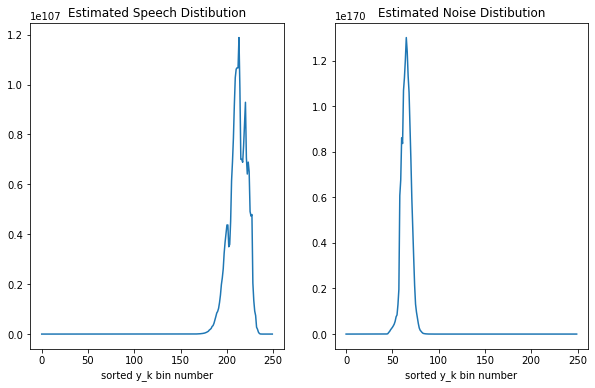

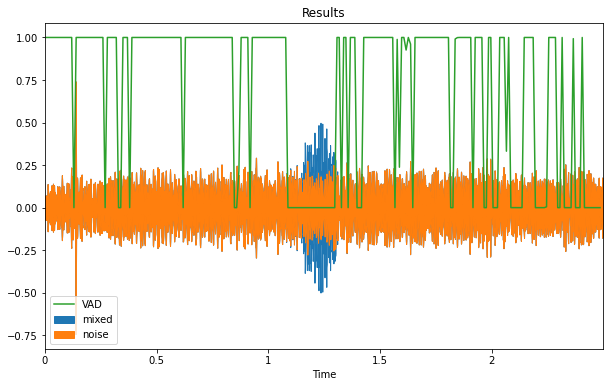

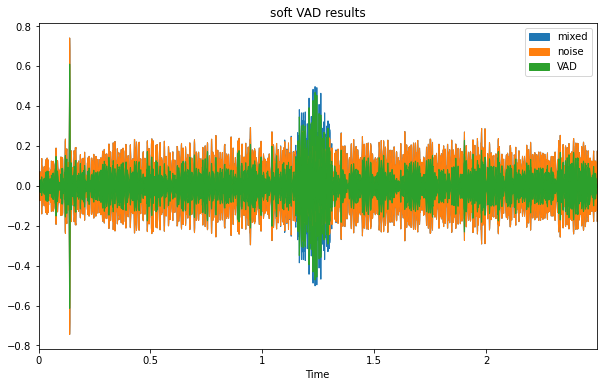

In [5]:
# 3. frequency doamin VAD using dual Rayleigh mixture model
#####################################################################
# 노이즈와 음성신호를 둘다 rayleigh distribution으로 가정한다.
# 그리고 EM 알고리즘으로 파라미터 sigma (mode를 의미한다.)를 추정한다.
#####################################################################

def rayleigh(x,sig2): # rayleigh distribution
    # x : 입력 데이터
    # sig2 : 파라미터 sig의 제곱    
    return np.exp(np.sum(np.log(x),axis=0)-np.sum(np.log(sig2),axis=0)-np.sum((x**2)/(2*sig2),axis=0))

def EM_Rayleigh(y_k,sig_x,sig_n,P_voice): # 다변수 rayleigh distribution의 EM알고리즘
    # y_k : 입력 데이터
    # sig_x : 음성신호의 파라미터 sig의 제곱    
    # sig_n : 노이즈의 파라미터 sig의 제곱 
    # P_voice : 음성이 있을 확률
    prob= lambda x,sig2 : np.exp(np.sum(np.log(x),axis=0)-np.sum(np.log(sig2),axis=0)-np.sum((x**2)/(2*sig2),axis=0))
    gamma=lambda fx,fy,P_voice : P_voice*(fx)/(P_voice*fx+(1-P_voice)*fy)
    for iter in range(30):
        Px=prob(y_k,sig_x)# fx(y)
        Pn=prob(y_k,sig_n)# fn(y)
        P_v=gamma(Px,Pn,P_voice).reshape(1,-1)# P(voice | y)
        for idx in range(P_v.size):
            if int(np.isnan(P_v[0,idx])):
                if idx < P_v.size//2:
                    P_v[0,idx]=0
                else:
                    P_v[0,idx]=1        
        P_voice=np.mean(P_v)
        sig_x_tmp=(np.mean(P_v*(y_k**2),axis=-1)/(2*P_voice)).reshape(-1,1)
        sig_n_tmp=(np.mean((1-P_v)*(y_k**2),axis=-1)/(2-2*P_voice)).reshape(-1,1)
        for k_idx in range(np.size(sig_x_tmp)): # sigma_x > sigma_n이 지켜지도록 조정
            if sig_x_tmp[k_idx]>sig_n_tmp[k_idx]:
                sig_x[k_idx]=sig_x_tmp[k_idx]
                sig_n[k_idx]=sig_n_tmp[k_idx]
            else:
                sig_x[k_idx]=sig_n_tmp[k_idx]
                sig_n[k_idx]=sig_x_tmp[k_idx]
        
    return P_v, sig_x, sig_n, P_voice


Y=Spectrogram(x,Ns,Nf,1)
print(Y.shape, max_iter)
y_k=np.abs(Y)
# y_k[y_k<1e-5]=1e-5
P_voice=0.5

y_k.sort(axis=-1)
# 파라미터 sigma의 추정
sig_n2=np.mean(y_k[:,:max_iter//2]**2,axis=-1)/2
sig_x2=np.mean(y_k[:,max_iter//2:]**2,axis=-1)/2

sig_x2=sig_x2.reshape(-1,1)
sig_n2=sig_n2.reshape(-1,1)
P_v,sig_x,sig_n,P_voice=EM_Rayleigh(y_k,sig_x2,sig_n2,P_voice) # EM 알고리즘

# 시각화
####################################################################
# 우리의 가정대로, sigma_x > sigma_n이 지켜지고 있는 것을 알 수 있다.
####################################################################

plt.figure(figsize=[10,6])
plt.subplot(1,2,1)
plt.plot(np.arange(max_iter),rayleigh(y_k,sig_x))
plt.title("Estimated Speech Distibution")
plt.xlabel("sorted y_k bin number")
plt.subplot(1,2,2)
plt.plot(np.arange(max_iter),rayleigh(y_k,sig_n))
plt.title("Estimated Noise Distibution")
plt.xlabel("sorted y_k bin number")

soft_VAD=np.zeros(max_iter)
Y_abs=np.abs(Y)
mem_xsoft=np.zeros(order-1+Nover)
y_soft=np.zeros(max_iter*Ns)                            
for idx in range(max_iter):
    x_i=x[(idx)*Ns:(idx)*Ns+Nf]
    y_i=Y_abs[:,idx].reshape(-1,1)
    decision_tmp=Soft_Decision(P_voice,
                               rayleigh(y_i,sig_n),
                               rayleigh(y_i,sig_x)
                               )
    soft_VAD[idx]=decision_tmp # soft decision
    h_soft=get_Wiener_filter(x_i,Ns,Nf,order,np.abs(sig_n).reshape(-1))
    y_tmp,mem_xsoft = filtering(h_soft,
                            x_i,
                            mem_xsoft,
                            Nover+Nf
                           )#  Wiener filter의 적용
    y_soft=trapezoidal_mixing(idx+1, Nf,Nover,y_soft,y_tmp,upslope)
####################################################################
# 노이즈가 있는 프레임에서 1을 출력하고, 
# 그 외에서 거의 0에 가까운 값을 출력하는 것으로 봐서,
# VAD가 잘 돌작하는 것 같다.
# Dual gaussian에 비해서 음성신호가 있는 부분에 대한 판단이 명확해서
# 음성신호의 왜곡은 적은 상태로 노이즈를 줄였음을 확인할 수 있다.
####################################################################
plt.figure(figsize=[10,6])
librosa.display.waveplot(x,Fs)
librosa.display.waveplot(n,Fs)
plt.plot(np.arange(0,max_iter)*Ns/Fs,soft_VAD) # 노이즈의 확률 추정
plt.title("Results")
plt.legend(["VAD","mixed","noise"])

plt.figure(figsize=[10,6])
librosa.display.waveplot(x,Fs)
librosa.display.waveplot(n,Fs)
librosa.display.waveplot(y_soft,Fs)
plt.title("soft VAD results")
plt.legend(["mixed","noise","VAD"])

soundfile.write("./03_result_Rayleigh.wav",y_soft,Fs,format="WAV")


<ipython-input-6-18a9a6affc9e>:24: RuntimeWarning: invalid value encountered in true_divide
  P_v=(P_voice*Px)/(P_voice*Px+(1-P_voice)*Pn).reshape(1,-1) # P(voice|y)
<ipython-input-3-77fe21e2d023>:17: RuntimeWarning: invalid value encountered in true_divide
  P_n_given_y=(1-P_voice)*P_n/denom


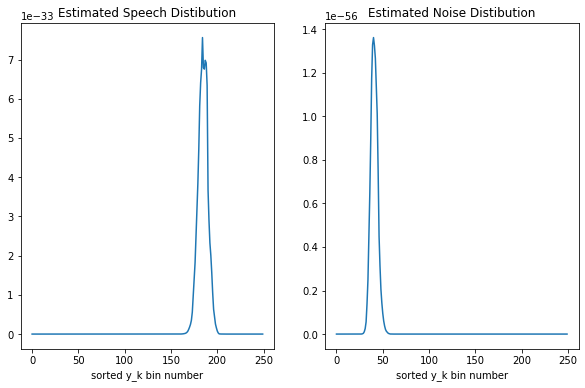

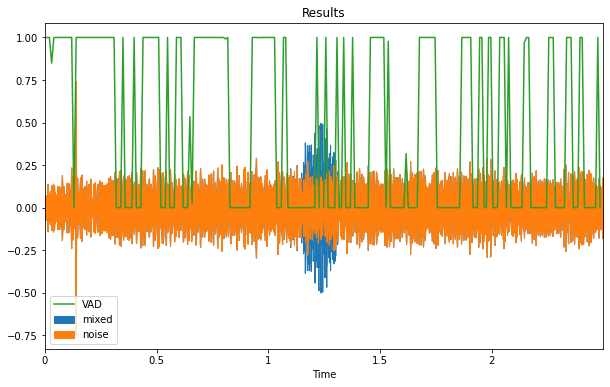

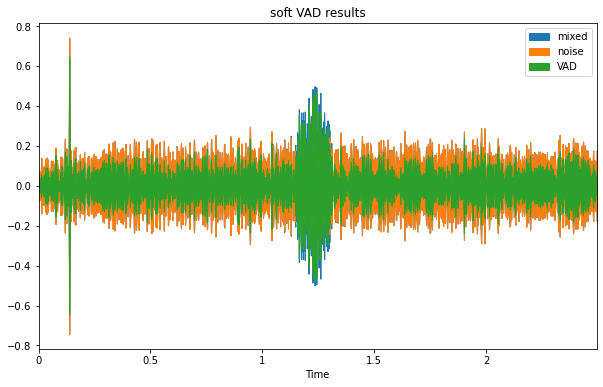

In [6]:
# 4. log-frequency domain VAD using dueal log Normal mixture model
####################################################################
# 입력신호dml 에너지에 log를 씌워서 그 분포가 gaussian 이라 가정한다.
# EM이 zero-mean이 아니기 때문에 평균도 같이 갱신해줘야한다.
####################################################################

def ShiftedGauss(x,mu,sig2): # 다변수 zero-mean이 아닌 joint gaussian
    # x : 입력 데이터
    # mu : 평균
    # sig2 : 분산
    return np.prod(np.exp(-((x-mu)**2)/(2*sig2))/(np.sqrt(2*np.pi*sig2)),axis=0)

def EM_ShiftedGauss(y_k,mean_x,mean_n,sig_x,sig_n,P_voice):# EM 알고리즘
    # y_k : 입력데이터 (프레임에너지의 log값)
    # mean_x : 음성신호의 평균
    # mean_n : 노이즈의 평균
    # sig_x : 음성신호의 분산
    # sig_n : 노이즈의 분산
    # P_voice : 음성신호가 있을 확률
    prob= lambda x,m_x,sig2 : np.prod(np.exp(-((x-m_x)**2)/(2*sig2))/(np.sqrt(2*np.pi*sig2)),axis=0)
    for iter in range(30):
        Px=prob(y_k,mean_x,sig_x).reshape(1,-1) # fx(y)
        Pn=prob(y_k,mean_n,sig_n).reshape(1,-1)# fn(y)
        P_v=(P_voice*Px)/(P_voice*Px+(1-P_voice)*Pn).reshape(1,-1) # P(voice|y)
        for idx in range(P_v.size):
            if int(np.isnan(P_v[0,idx])):
                if idx < P_v.size//2:
                    P_v[0,idx]=0
                else:
                    P_v[0,idx]=1
        P_voice=np.mean(P_v)
        mean_x_tmp=(np.mean(P_v*y_k,axis=-1)/P_voice).reshape(-1,1)
        mean_n_tmp=(np.mean((1-P_v)*y_k,axis=-1)/(1-P_voice)).reshape(-1,1)            

        sig_x_tmp=(np.mean(P_v*((y_k-mean_x_tmp)**2),axis=-1)/P_voice).reshape(-1,1)
        sig_n_tmp=(np.mean((1-P_v)*((y_k-mean_n_tmp)**2),axis=-1)/(1-P_voice)).reshape(-1,1)
        for idx in range(np.size(mean_n)): # 모든 Freq bin에서 평균이 더 큰 것이 speech라고 가정한다,
            if mean_x_tmp[idx] > mean_n_tmp[idx]:
                mean_x[idx]=mean_x_tmp[idx]
                mean_n[idx]=mean_n_tmp[idx]
                sig_x[idx]=sig_x_tmp[idx]
                sig_n[idx]=sig_n_tmp[idx]
            else:
                mean_x[idx]=mean_n_tmp[idx]
                mean_n[idx]=mean_x_tmp[idx]
                sig_x[idx]=sig_n_tmp[idx]
                sig_n[idx]=sig_x_tmp[idx]
                
    return P_v,mean_x,mean_n,sig_x, sig_n,P_voice

Y=Spectrogram(x,Ns,Nf,1)

y_k=np.log(np.abs(Y))*2 # log된 에너지를 입력으로 이용한다.
P_voice=0.5

y_k.sort(axis=-1)    
mean_n=np.mean(y_k[:,:max_iter//2],axis=-1).reshape(-1,1)
mean_x=np.mean(y_k[:,max_iter//2:],axis=-1).reshape(-1,1)

sig_n2=np.mean((y_k[:,:max_iter//2]-mean_n)**2,axis=-1).reshape(-1,1)
sig_x2=np.mean((y_k[:,max_iter//2:]-mean_x)**2,axis=-1).reshape(-1,1)
P_v,mean_x,mean_n,sig_x,sig_n,P_voice=EM_ShiftedGauss(y_k,mean_x,mean_n,sig_x2,sig_n2,P_voice)


# 시각화
####################################################################
# rayleigh분포보다 gaussian 분포가 더 넓어 보이는 것을 확인할 수 있다.
# log를 통해 y_k의 값이 더 조밀해지는 효과를 얻었고,
# 때문에 더 자세히 볼 수 있는 것이라 생각된다.
# 이전의 sigma와 유사하게, 두 분포의 평균이 음성신호가 더 큰 것을 알 수 있다.
####################################################################

plt.figure(figsize=[10,6])
plt.subplot(1,2,1)
plt.plot(np.arange(max_iter),ShiftedGauss(y_k,mean_x,sig_x))
plt.title("Estimated Speech Distibution")
plt.xlabel("sorted y_k bin number")
plt.subplot(1,2,2)
plt.plot(np.arange(max_iter),ShiftedGauss(y_k,mean_n,sig_n))
plt.title("Estimated Noise Distibution")
plt.xlabel("sorted y_k bin number")

soft_VAD=np.zeros(max_iter)
Y_abs=np.log(np.abs(Y))*2
mem_xsoft=np.zeros(order-1+Nover)
y_soft=np.zeros(max_iter*Ns)                            

for idx in range(max_iter):
    x_i=x[(idx)*Ns:(idx)*Ns+Nf]
    y_i=Y_abs[:,idx].reshape(-1,1)
    decision_tmp=Soft_Decision(P_voice,
                               ShiftedGauss(y_i,mean_n,sig_n),
                               ShiftedGauss(y_i,mean_x,sig_x)
                               )
    soft_VAD[idx]=decision_tmp
    h_soft=get_Wiener_filter(x_i,Ns,Nf,order,np.exp(mean_n).reshape(-1))
    y_tmp,mem_xsoft = filtering(h_soft,
                            x_i,
                            mem_xsoft,
                            Nover+Nf
                           )#  Wiener filter의 적용
    y_soft=trapezoidal_mixing(idx+1, Nf,Nover,y_soft,y_tmp,upslope)


####################################################################
# 노이즈의 확률 추정은 생각보다 잘 동작하지 않았다.
# 아마도 가정에 틀린 부분이 있기 때문이라 생각된다.
# Dual gaussian에 비하면 음성신호의 왜곡이 적음을 확인할 수 있다.
####################################################################

plt.figure(figsize=[10,6])
librosa.display.waveplot(x,Fs)
librosa.display.waveplot(n,Fs)
plt.plot(np.arange(0,max_iter)*Ns/Fs,soft_VAD) # 노이즈의 확률 추정
plt.title("Results")
plt.legend(["VAD","mixed","noise"])

plt.figure(figsize=[10,6])
librosa.display.waveplot(x,Fs)
librosa.display.waveplot(n,Fs)
librosa.display.waveplot(y_soft,Fs)
plt.title("soft VAD results")
plt.legend(["mixed","noise","VAD"])

soundfile.write("./04_result_loged_Gaussian.wav",y_soft,Fs,format="WAV")
